长短期记忆网络公式：
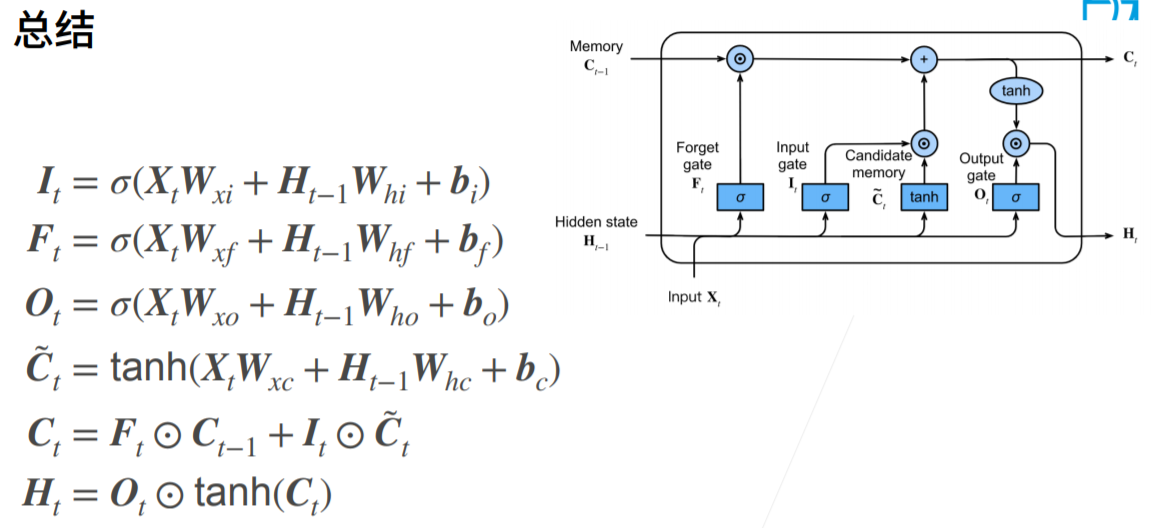

# 从零实现LSTM

In [1]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35 # B, T
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps) # 训练数据，字典

def get_lstm_params(vocab_size, num_hiddens, device): # 初始化训练参数
    num_inputs = num_outputs = vocab_size # 因为使用的是one-hot编码，所有特征就是字典的长度

    def normal(shape): # 生成均值为0方差为0.01的正态分布
        return torch.randn(size=shape, device=device) * 0.01

    def three(): # lstm中,I,F,O,候选C的训练参数形状都一样，用一个函数包装而已
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three() # I
    W_xf, W_hf, b_f = three() # F
    W_xo, W_ho, b_o = three() # O
    W_xc, W_hc, b_c = three() # 候选C
    
    # lstm输出为C和H，没有output，因此我们给H加一个全连接层，构造输出层，这里是参数
    W_hq = normal((num_hiddens, num_outputs)) 
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params: # 使得每个参数可以求导
        param.requires_grad_(True)
    return params

初始化函数：这个初始化就是说：LSTM刚开始是没有H和C的，因此，需要我们初始化这两个状态

In [2]:
def init_lstm_state(batch_size, num_hiddens, device): # H和C形状一样，放一起初始化了
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型

In [3]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state # 初始状态有两个：H和C，注意和GRU不同（GRU只有一个）
    outputs = [] # 输出需要我们自己构造，把每次的输出放入一个list中，最后在dim=0维度拼接起来
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q # 这个就是构造输出层，其实就是在H后面加了一个全连接层
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C) # 将输出拼接，并返回了H和C（H和C在下一时刻要用）

训练

perplexity 1.1, 34290.0 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller a cond in time and any of the three dimensions of


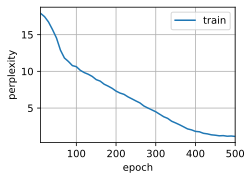

In [4]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# LSTM的简洁实现（pytorch）

perplexity 1.1, 332398.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


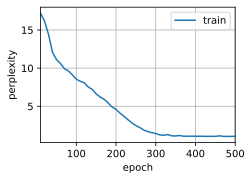

In [5]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens) # 输入特征个数，隐藏状态个数
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)